In [78]:
# Importando as bibliotecas gerais:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit

# Importando as bibliotecas Scikit Learn:
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_circles
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score


In [79]:
# Definição dos centros:
centers = [[-5, 0], [0, 1.5], [5, -1]]

# Geração do dataset:
x, y = make_blobs(n_samples=1000, centers=centers, random_state=42)

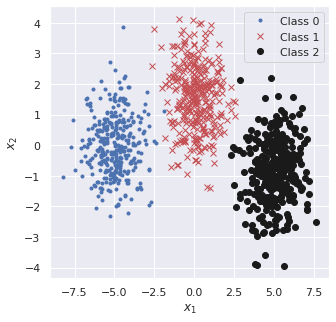

In [80]:
# Plotagem dos dados gerados:
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)
idx2 = np.argwhere(y == 2)
fig = plt.figure(figsize=(5,5))
plt.plot(x[idx0,0], x[idx0,1], '.', label='Class 0')
plt.plot(x[idx1,0], x[idx1,1], 'rx', label='Class 1')
plt.plot(x[idx2,0], x[idx2,1], 'ko', label='Class 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()


In [81]:
def to_one_hot(y):
  n_classes = y.max() + 1
  m = len(y)
  Y_one_hot = np.zeros((m, n_classes))
  Y_one_hot[np.arange(m), y] = 1
  return Y_one_hot

def softmax(logits):
  exps = np.exp(logits)
  exp_sums = np.sum(exps, axis=1, keepdims=True)
  return exps / exp_sums

def error_function(x, a, y, epsilon=1e-7):
  logits = x.dot(a)
  y_prob = softmax(logits)
  error = -np.mean(np.sum(y * np.log(y_prob + epsilon), axis=1))
  return error

def classifier(x, a):
  logits = x.dot(a)
  y_prob = softmax(logits)
  c = np.zeros((len(y_prob), 1))
  for i in range(0, len(y_prob)):
    c[i, 0] = np.argwhere(y_prob[i,:] == y_prob[i,:].max())[0]
  return c


h(x) = f(a0 + a1x1 + a2x2)

In [82]:
# Definindo epsilon
ep = 1e-7

# Definindo o tamanho de teste:
t_size = 0.25

In [83]:
# Dividindo o dataset em treinamento e teste:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=t_size)

# Adicionando o BIAS no conjunto treinamento:
x_train = np.c_[np.ones((len(y_train), 1)), x_train]

# Adicionando o BIAS no conjunto teste:
x_test = np.c_[np.ones((len(y_test), 1)), x_test]

# Copiando os dados de test para comparação:
y_orig = y_test

# One hot encoding:
y_train = to_one_hot(y_train)
y_test  = to_one_hot(y_test)

In [104]:
# Batch gradient descent solution.

# Definindo o passo de aprendizagem:
alpha = 0.06

# Definindo o número máximo de iteração:
n_iterations = 2000

# Randomizando os parâmetros iniciais:
a = np.random.randn(x_train.shape[1], y_train.shape[1])

# Criando vetores para armazenamento do erro:
Jgd = np.zeros(n_iterations+1)
Jgd_v = np.zeros(n_iterations+1)

# Calculando o erro inicial:
Jgd[0] = error_function(x_train, a, y_train, ep)
Jgd_v[0] = error_function(x_test, a, y_test, ep)

# LOOP do gradiente descendente batelada:
minimum_val_error = float("inf")

# Definindo os valores iniciais para iteração e erro:
iteration = 0
error = 1

while iteration < n_iterations:

    # Softmax
    logits = x_train.dot(a)
    y_prob = softmax(logits)

    # Executa o gradiente
    gradients = 1/len(y_train)*x_train.T.dot(y_prob - y_train)
    # Encontra o valor de alpha
    a = a - alpha*gradients
    # Armazena o erro encontrado:
    Jgd[iteration+1] = error_function(x_train, a, y_train, ep)
    Jgd_v[iteration+1] = error_function(x_test, a, y_test, ep)
    error = np.abs(Jgd[iteration+1] - Jgd[iteration])

    # Critério de parada (Early Stoping):
    if(Jgd_v[iteration+1] < minimum_val_error):
        minimum_val_error = Jgd_v[iteration+1]
        a_min = a        
    iteration = iteration + 1

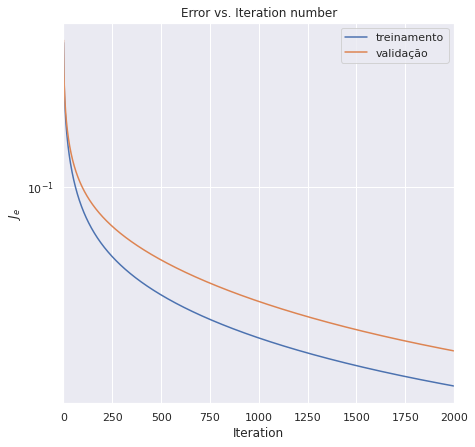

In [105]:
# Plotando o ERRO vs ITERAÇÃO:
fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

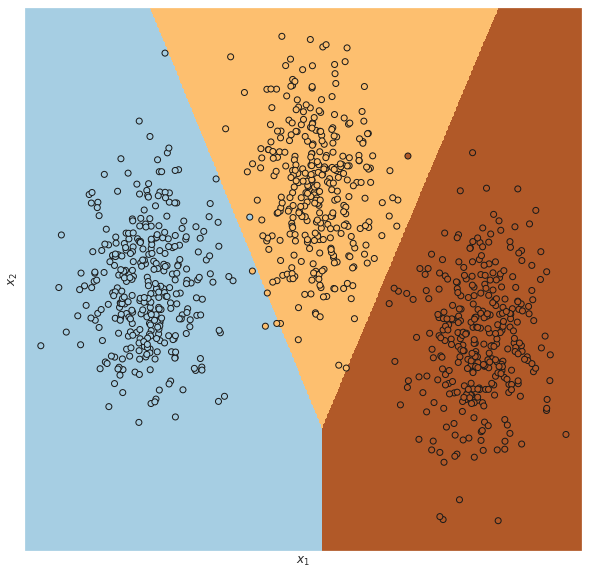

In [106]:
# Plotando a fronteira de decisão:
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
h = .02  
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = classifier(np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()], a_min)

Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

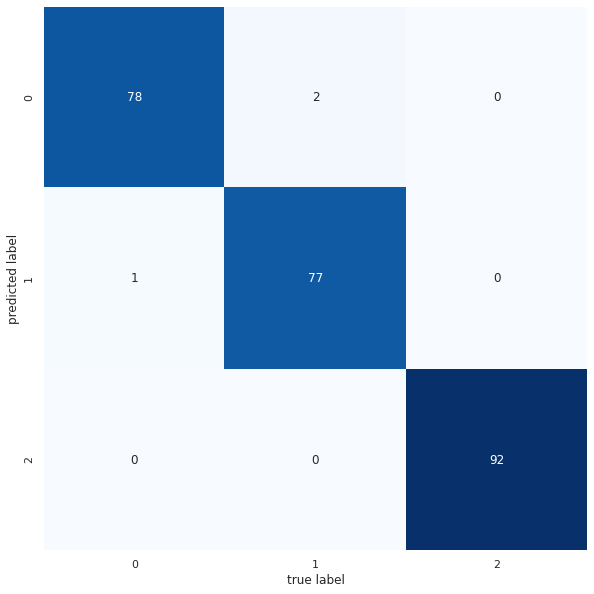

In [107]:
y_pred_class = classifier(x_test, a_min)

# Plotando a matriz de confusão:
fig = plt.figure(figsize=(10,10))
mat = confusion_matrix(y_orig, y_pred_class)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1','2'], yticklabels=['0','1','2'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [108]:
# Imprimindo o relatório:
print(classification_report(y_orig, y_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        79
           1       0.99      0.97      0.98        79
           2       1.00      1.00      1.00        92

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

